### Initialize environment

This cell block checks the required modules (and installs them if missing) before importing them.

In [1]:
%%capture 
# hide the output of this cell block

%pip install qiskit # check & install qiskit if missing
%pip install pylatexenc #check & install pylatexenc (required for images with complex symbols) if missing
import matplotlib.pyplot as plt
import numpy as np
import math
import pylatexenc

# importing Qiskit
from qiskit import *
from qiskit.visualization import *
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq.job import job_monitor
from qiskit.extensions import UnitaryGate
from qiskit.circuit.library import QFT
from qiskit.converters import circuit_to_gate

# import basic plot tools
from qiskit.visualization import plot_histogram
%matplotlib inline 

#Set up simulators
aer_sim = Aer.get_backend('aer_simulator')
M_sim = Aer.get_backend("qasm_simulator")
S_sim = Aer.get_backend("statevector_simulator")
U_sim = Aer.get_backend("unitary_simulator")

### Build the circuit for Grover's Search Algorithm

This cell block runs defines the circuit for Grover's Search Algorithm.

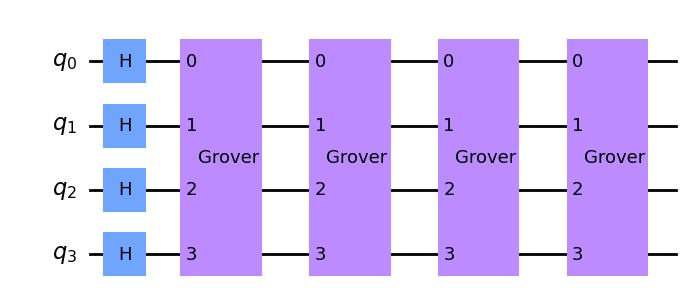

In [2]:
n = 4 # number of qubits with size of database, N = 2^n
w_state = 0b0101 # winner state

grover_circuit = QuantumCircuit(n)

# define initialization in equal superposition
def initialize_s(qc, nqubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in range(nqubits):
        qc.h(q)
    return qc

# define oracle Operator (U_w)
def oracle(nqubits,winner):
    #NXN identity matrix
    w = np.identity(2**nqubits)
    #Apply phase to winner state
    w[int(winner)][int(winner)] = -1
    #convert the matrix to gate
    U_w = UnitaryGate(w, label = 'U$_\omega$')
    return U_w

# define diffusion operator (U_s)
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for i in list(range(nqubits)):
      qc.h(i)
    #NXN identity matrix
    s = np.identity(2**nqubits)
    #Apply phase to winner states
    for i in list(range(1,2**nqubits)):
      s[i][i] = -1
    #convert the matrix to gate
    U = UnitaryGate(s)
    qc.append(U,list(range(nqubits)))
    for i in list(range(nqubits)):
      qc.h(i)
    U_s = circuit_to_gate(qc, label = 'U$_s$')
    return U_s

# define one Grover iteration
def gr_iteration(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.append(oracle(n,w_state),list(range(n)))
    qc.append(diffuser(n), list(range(n)))
    gr_iter = circuit_to_gate(qc,label='Grover')
    return gr_iter

#initialize in equal superposition
grover_circuit = initialize_s(grover_circuit, n)

# iterate SQRT(N) times
for i in range(math.floor(2**(n/2))):
    grover_circuit.append(gr_iteration(n),list(range(n)))


grover_circuit.draw('mpl')


### Simulate the circuit for Grover's Algorithm and get results



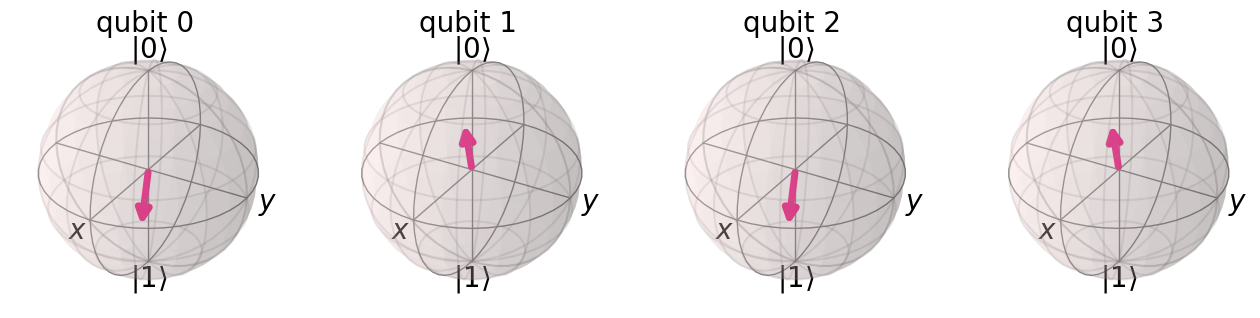

In [3]:
s_result = execute(grover_circuit, S_sim).result()
statevec = s_result.get_statevector()
array_to_latex(statevec, prefix="|\\psi\\rangle =")
statevec.draw('bloch')

In [4]:
grover_circuit.measure_all()

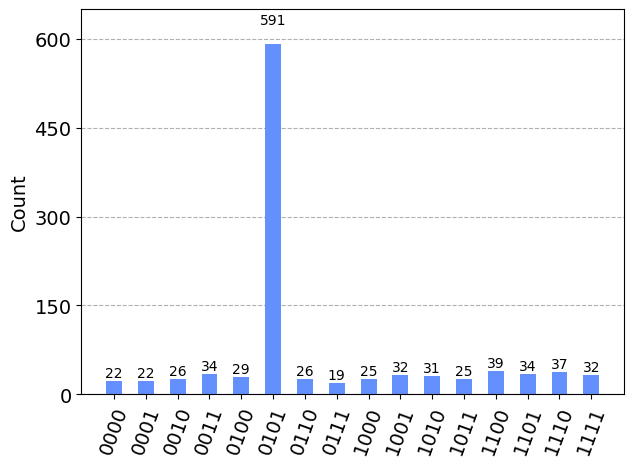

In [5]:
gr_sim_job = execute(grover_circuit, backend = aer_sim, shots = 1024)
gr_sim_result = gr_sim_job.result()
gr_sim_counts = gr_sim_result.get_counts()
plot_histogram(gr_sim_counts)


In [6]:
print("The winner state is %s" % max(gr_sim_counts, key=gr_sim_counts.get))

The winner state is 0101


### Run the Grover'sAlgorithm on IBM's hardware

Check IBM's hardware queues before running the three cell blocks below. Change the device to one that has the shortest queue after checking on https://quantum-computing.ibm.com/services/resources?tab=systems&limit=30.

You will also need to get your API token from IBM and add it in the cell block below.

In [25]:
#Set up IBM's quantum hardware
api = ""
IBMQ.save_account(api)
provider = IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = provider.get_backend('ibmq_manila')

In [ ]:
transpiled_grover_circuit = transpile(grover_circuit, optimization_level=3)
gr_job = execute(transpiled_grover_circuit, backend = device, shots = 1024)
job_monitor(gr_job, interval=2)

In [ ]:
gr_job_results = gr_job.result()
gr_job_counts = results.get_counts(gr_job_results)
plot_histogram(gr_job_counts)

### Quantum Fourier Transform & Inverse QFT

QFT is an in-built class in qiskit. However, for the Phase Estimation part, we need the inverse QFT gate.

We define this gate in the next cell block.

In [8]:
def inv_qft(nqubits):
    qft_dagger = QFT(nqubits).to_gate().inverse()
    qft_dagger.label = 'QFT†'
    return qft_dagger


### Build the Circuit for Quantum Counting Alorithm

In [39]:
qcn = 2
qct = 3
w_states = [0b01,0b10,0b11]

qc = QuantumCircuit(qct+qcn,qct)

def qc_oracle(nqubits,winner):
    #NXN identity matrix
    w = np.identity(2**nqubits)
    #Apply phase to winner states
    for state in w_states:
        w[int(state)][int(state)] = -1
    #convert the matrix to gate
    U_w = UnitaryGate(w, label = 'U$_\omega$')
    return U_w

def qc_diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for i in list(range(nqubits)):
      qc.h(i)
    #NXN identity matrix
    s = np.identity(2**nqubits)
    s*=-1
    s[0][0]=1
    #convert the matrix to gateU = UnitaryGate(s)
    U = UnitaryGate(s)
    qc.append(U,list(range(qcn)))
    for i in list(range(qcn)):
        qc.h(i)
    U_s = circuit_to_gate(qc, label = 'U$_s$')
    return U_s

# define one Grover iteration
def qc_gr_iteration(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.append(qc_oracle(qcn,w_states),list(range(qcn)))
    qc.append(diffuser(qcn), list(range(qcn)))
    qc_gr_iter = circuit_to_gate(qc,label='Grover')
    return qc_gr_iter

#define controlled grover iteration
cgr_iter = qc_gr_iteration(qcn).control()


#Initialize all qubits to |+>
for i in range(qct+qcn):
    qc.h(i)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(qct):
    for i in range(iterations):
        qc.append(cgr_iter, [qubit] + [*range(qct, qcn+qct)])
    iterations *= 2

#Phase estimation
qc.append(inv_qft(qct), list(range(qct)))

qc.measure(range(qct), range(qct))

In [ ]:
#only run this cell if qcn+qct<5 in previous cell
qc.draw('mpl')

### Simulate the circuit for Quantum Counting Algorithm and get results

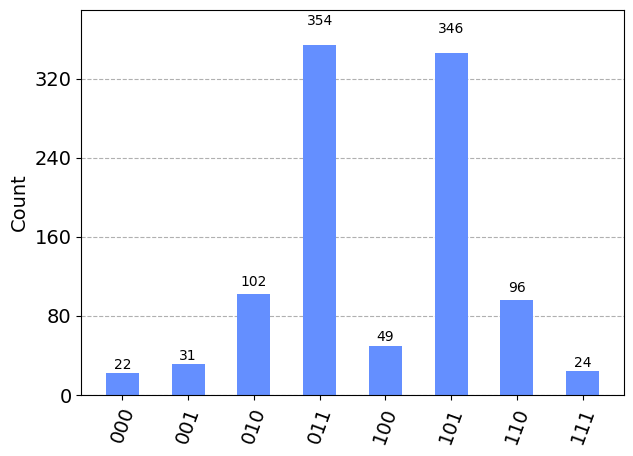

In [43]:
qc_sim_job = execute(qc, backend = aer_sim, shots = 1024)
qc_sim_result = qc_sim_job.result()
qc_sim_counts = qc_sim_result.get_counts()
plot_histogram(qc_sim_counts)

### Run the Quantum Counting Algorithms on IBM's hardware

Check IBM's hardware queues before running the three cell blocks below. Change the device to one that has the shortest queue after checking on https://quantum-computing.ibm.com/services/resources?tab=systems&limit=30.

You will also need to get your API token from IBM and add it in the cell block below.

Make sure the number of qubits in your circuit is less than or equal to the qubits on the hardware.

In [40]:
transpiled_qc = transpile(qc, optimization_level=3)
qc_job = execute(qc, backend = device, shots = 1024)
job_monitor(qc_job, interval=2)

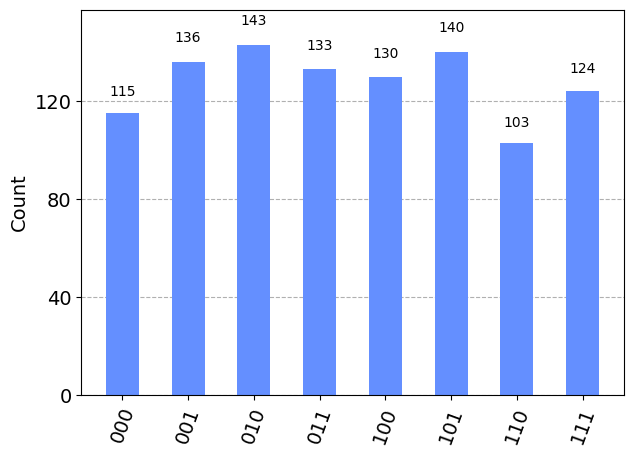

In [41]:
qc_job_results = qc_job.result()
qc_job_counts = qc_job_results.get_counts()
plot_histogram(qc_job_counts)

### Decoding the results

Simulation Result Analysis

In [44]:
measured_str = max(qc_counts, key=qc_counts.get)
measured_int = int(measured_str,2)
print("Measured Value = %i" % measured_int)
theta = (measured_int/(2**qct))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**qcn
M = N * (math.sin(theta/2)**2)
print("No. of Winner States = %.1f" % M)

Measured Value = 3
Theta = 2.35619
No. of Winner States = 3.4


Hardware Result Analysis

In [42]:
measured_str = max(qc_job_counts, key=qc_job_counts.get)
measured_int = int(measured_str,2)
print("Measured Value = %i" % measured_int)
theta = (measured_int/(2**qct))*math.pi*2
print("Theta = %.5f" % theta)
N = 2**qcn
M = N * (math.sin(theta/2)**2)
print("No. of Winner States = %.1f" % M)

Measured Value = 2
Theta = 1.57080
No. of Winner States = 2.0
